<a href="https://colab.research.google.com/github/Manav-Aggarwal4/CS50-Finance/blob/main/mlp_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torchvision
from torchvision import transforms


#--------------------------------------------------------------------
# 1) Prepare MNIST data
#--------------------------------------------------------------------
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

X_train = train_dataset.data.numpy().astype(np.float32) / 255.0
X_train = X_train.reshape(60000, 784)
y_train = train_dataset.targets.numpy()
X_test = test_dataset.data.numpy() .astype(np.float32) / 255.0
X_test = X_test.reshape(10000, 784)
y_test = test_dataset.targets.numpy()

def one_hot_encode(y, num_classes=10):
    one_hot = np.zeros((y.shape[0], num_classes))
    one_hot[np.arange(y.shape[0]), y] = 1
    return one_hot

y_train_onehot = one_hot_encode(y_train, num_classes=10)
y_test_onehot = one_hot_encode(y_test, num_classes=10)

# MLP Review

A multi-layer perceptron (MLP) has 3 types of layers:

*   **Read-in Layer**: This is your input layer. Its dimensions must match that of your input data.
*   **Hidden Layer(s)**: These are the layers between your read-in and read-out layers. This is where the model learns some representation of the data and uses it to produce the output.
*   **Read-out Layer**: This is your output layer. Its dimensions must match that of your target data.

Each layer is composed of multiple perceptron. A perceptron looks like this:
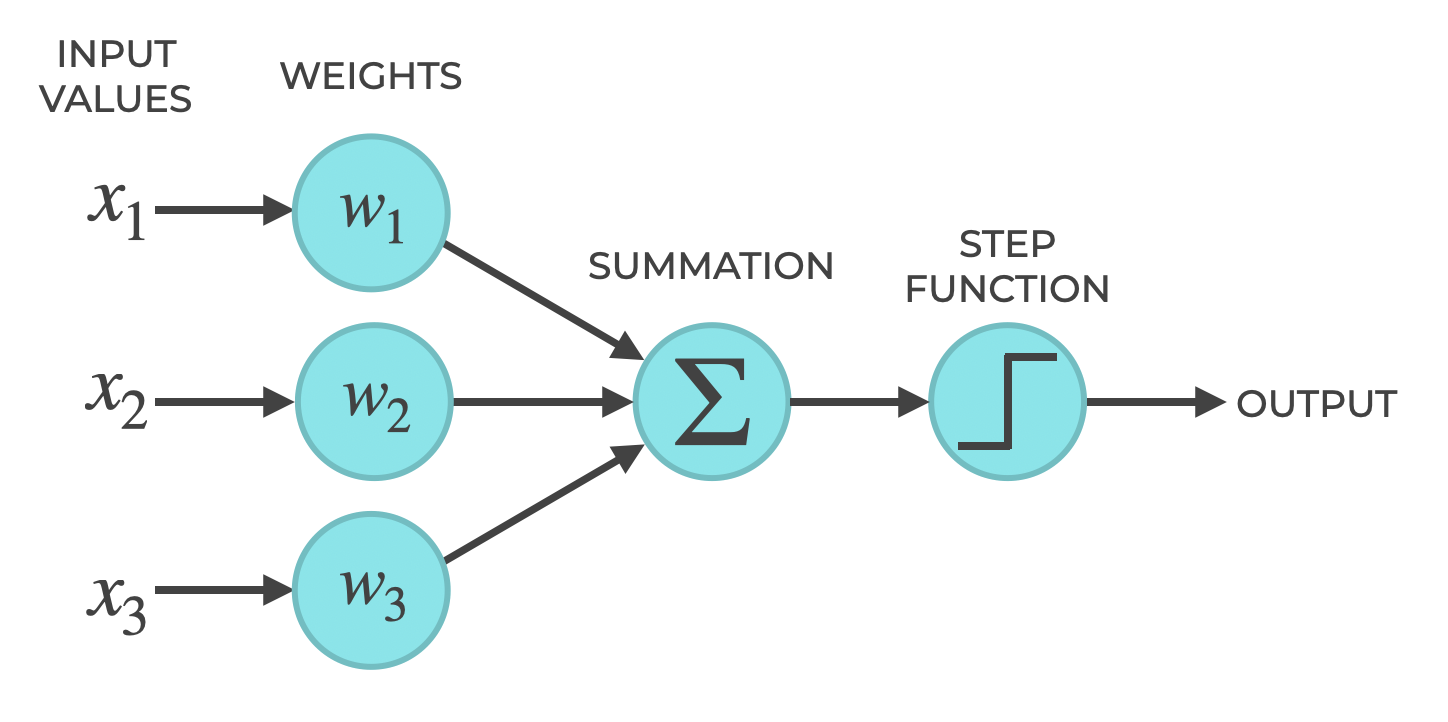

where the value of each neuron is computed as some weighted sum of the previous layer's values + a bias term (not shown in the image), all ran though some non-linear (depicted as a step-function in the image) function.

A few important notes:

*   **Bias:** This just allows us to vertically shift our weighted sum (think of how a line is only able to rotate about the origin without the y-intercept term).
*   **Non-linearity is a must:** If the function is linear, increasing the depth of the model (adding more hidden layers) wouldn't actually do anything! We'll work this out mathematically later. There's also a nice visualization on what these nonlinearities actually do: https://www.youtube.com/watch?v=pdNYw6qwuNc, around 6 minutes in.
*   **Must be differentiable:** This is helpful for the backward pass of our model, where we update parameters. Using a differentiable function allows us to determine how much to change each parameter.

The image above is also motivated a bit more by neuroscience than ML so thats why their activation function is a step function and there isn't a bias term, but in ML, we usually have a bias term and any non-linear differentiable function works as an activation function.

When we stack multiple perceptrons, our MLP looks more like this:
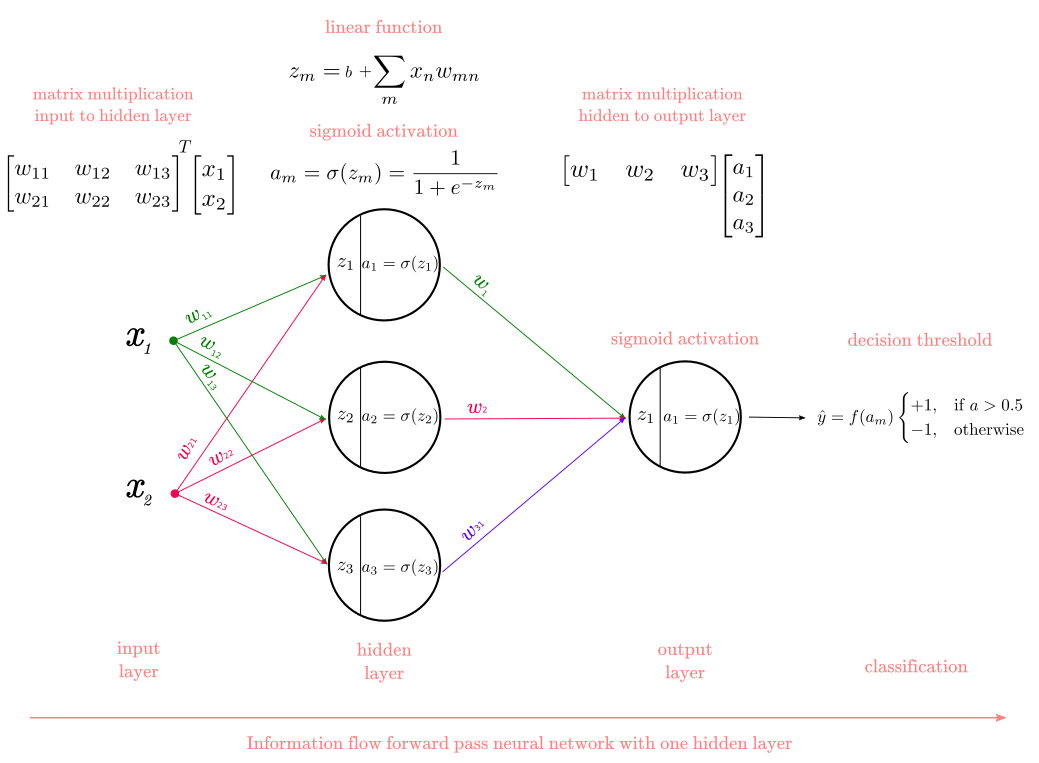

Okay now lets put the image into math:

For a neuron, we first take a weighted sum of the previous layer's values and add in our bias term:

$$z = w_1x_1 + w_2x_2 + \cdots + w_nx_n + b$$

where $w$ denotes the weights, $x$ denotes the previous layer's values, and $b$ is our bias term.

Then, we run $z$ through some non-linear function (let's call it $\sigma$), to get our neuron's final activation value:

$$a = \sigma(z) = \sigma(w_1x_1 + w_2x_2 + \cdots + w_nx_n + b)$$

This is very conveniently expressed in the notation of linear algebra. We can write each layer's values as a vector, and multiply by a weight matrix to get to a vector of the next layer's values.

Using the notation of linear algebra, we represent the inputs to the layer as a vector $\mathbf{x}$ and the weights connecting the inputs to the neurons in the next layer as a weight matrix $\mathbf{W}$. The bias terms for all neurons in the layer are represented as a bias vector $\mathbf{b}$.

The weighted sum of inputs plus bias for all neurons in the layer is then:

$$
\mathbf{z} = \mathbf{W}\mathbf{x} + \mathbf{b}
$$

Here, $\mathbf{W}$ is an $m \times n$ matrix where $m$ is the number of neurons in the current layer and $n$ is the number of neurons in the previous layer, $\mathbf{x}$ is an $n \times 1$ vector, and $\mathbf{b}$ is an $m \times 1$ vector.

Next, we apply a non-linear activation function $\sigma$ element-wise to the vector $\mathbf{z}$ to compute the activations of the neurons in the current layer:

$$
\mathbf{a} = \sigma(\mathbf{z}) = \sigma(\mathbf{W}\mathbf{x} + \mathbf{b})
$$

The activation vector $\mathbf{a}$ is then passed to the next layer as input.

# Writing the Forward Pass

In [ ]:
# For an input vector x, write a function to compute the value of the layer of neurons using the matrix-vector notation:
#  - a_1 = sigma(1 * x_1 + 2 * x_2 + 3 * x_3 + 4)
#  - a_2 = sigma(3 * x_1 + 2 * x_2 + 1 * x_3 + 4)

def sigma(x: np.array):
  return np.maximum(0, x)

def compute_activations(x: np.array) -> np.array:
    W = np.array([[1, 2, 3], [3, 2, 1]])  # Weight matrix
    b = np.array([4, 4])  # Bias vector
    x = x.reshape(-1, 1)
    return sigma((W @ x).flatten() + b)  # Matrix-vector multiplication and activation

In a feedforward neural network with multiple layers, this process is repeated for each layer. For the $l$-th layer, given the activations of the previous layer $\mathbf{a}^{(l-1)}$, the computations are:

1. Compute the pre-activation values:
   $$
   \mathbf{z}^{(l)} = \mathbf{W}^{(l)}\mathbf{a}^{(l-1)} + \mathbf{b}^{(l)}
   $$

2. Apply the activation function:
   $$
   \mathbf{a}^{(l)} = \sigma(\mathbf{z}^{(l)})
   $$

Here, $\mathbf{W}^{(l)}$ and $\mathbf{b}^{(l)}$ are the weight matrix and bias vector for the $l$-th layer, respectively.

For a network with $L$ layers, the output of the network is the activation vector of the last layer, $\mathbf{a}^{(L)}$.

In [ ]:
# For an input vector x, write a function to compute the output. The weights and biases are given (in the order they are applied). Assume each layer uses the same sigma.

weights = [np.array([[1, 0], [0, 1], [1, 1]]), np.array([[2, 3, 4]])]
biases = [0, 2]

def sigma(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def compute_output(x: np.array, weights: list[np.ndarray], biases: list[float]):
    for i in range(len(weights)):
        x = x.reshape(-1, 1) if x.ndim == 1 else x
        x = sigma((weights[i] @ x).flatten() + biases[i])
    return x

It's also helpful for us to write an activation function class right now, for use later.

In [ ]:
class ActivationFunction:
    def __init__(self, name):
        self.name = name

    def forward(self, x):
        if self.name == 'relu':
            return np.maximum(0, x)
        elif self.name == 'softmax':
            # Subtract max for numerical stability
            exps = np.exp(x - np.max(x, axis=1, keepdims=True))
            return exps / np.sum(exps, axis=1, keepdims=True)
        else:
            raise ValueError(f"Unsupported activation: {self.name}")

    def backward(self, x):
        if self.name == 'relu':
            return (x > 0).astype(x.dtype)
        elif self.name == 'softmax':
            exps = np.exp(x - np.max(x, axis=-1, keepdims=True))
            return exps / np.sum(exps, axis=-1, keepdims=True)
        else:
            raise ValueError(f"Unsupported activation: {self.name}")

Now, we can write a simple forward method that runs a forward pass through our network.

In [ ]:
class MLP:
  def __init__(self, input_size: int, hidden_sizes: list[int], output_size: int, activation_functions: list[ActivationFunction]):
    assert len(activation_functions) == len(hidden_sizes) + 1

    self.input_size = input_size
    self.output_size = output_size

    # randomly initalize weights and biases
    self.weights = [np.random.normal(loc=0, scale=1, size=(input_size, hidden_sizes[0]))]
    for i in range(len(hidden_sizes) - 1):
        self.weights.append(np.random.normal(loc=0, scale=1, size=(hidden_sizes[i], hidden_sizes[i + 1])))
    self.weights.append(np.random.normal(loc=0, scale=1, size=(hidden_sizes[-1], output_size)))
    self.biases = [np.random.normal(loc=0, scale=1, size=(out_dim,)) for out_dim in hidden_sizes + [output_size]]

    self.activation_functions = activation_functions

  def forward(self, x: np.array):
    for i in range(len(self.weights) - 1):
        x = self.activation_functions[i].forward(self.weights[i] @ x + self.biases[i])
    return x

Now, we can understand why we need the nonlinear functions.

If we only use linear transformations, regardless of the number of layers, the entire network can be simplified to a single linear function. For example, consider two layers of linear transformations:
  $$
  \mathbf{z} = W_2 (W_1 \mathbf{x} + b_1) + b_2
  $$
  Expanding this, we get:
  $$
  \mathbf{z} = (W_2 W_1) \mathbf{x} + (W_2 b_1 + b_2)
  $$
  This is still a linear function of $ \mathbf{x} $. Adding more layers doesn't change the fact that the network is still a linear transformation of the input. Thus, any number of layers can be collapsed into an equivalent network with just one hidden layer.


# Backprop (Math)

Now, we know how to make predictions, but we still don't have a way to update our weights. To do this, we'll run a backward pass through our network and compute how much each weight / bias needs to be changed by to decrease our loss.

Now, we know how to make predictions, but we still don't have a way to update our weights. To do this, we'll run a backward pass through our network and compute how much each weight / bias needs to be changed by to decrease our loss.

In our MLP class, we randomly initialized the weights and biases, so now all we need to do is figure out how much to change each weight/bias by. We can do this by taking derivatives of the loss w.r.t. each parameter and update it that way. Mathematically, we can express this as:

$$W_{t+1} = W_t - \eta \nabla W$$

Where we take the negative gradient because the gradient points in the direction of steepest ascent, so taking the negative gives a vector that points in the direction of steepest descent (because our goal is to minimize the loss).

To compute the gradient of the loss with respect to each parameter, we use the **backpropagation** algorithm. Backpropagation applies the chain rule to compute how much each parameter (weight or bias) contributed to the overall loss.

The general process is:
1. **Forward pass**: Compute the output of the network given the current weights and inputs.
2. **Loss calculation**: Compute the loss (or error) by comparing the network’s output with the true target values.
3. **Backward pass**: Compute the gradients of the loss with respect to each parameter using the chain rule, starting from the output layer and propagating backward through the layers.
4. **Parameter update**: Update each parameter using the gradient and the learning rate.

The learning rate $\eta$ is an important hyperparameter in this process. It indicates how much we step in the direction of steepest descent. If $ \eta $ is too large, the updates might overshoot the optimal values, causing the model to diverge. If $ \eta $ is too small, the learning process will be slow and might get stuck in local minima. In practice, we use adaptive gradient descent, momentum, etc to improve convergence, but here we'll just implement standard stochastic gradient descent.

In our MLP class, we randomly initialized the weights and biases, so now all we need to do is figure out how much to change each weight/bias by. We can do this by taking derivatives of the loss w.r.t. each parameter and update it that way. Mathematically, we can express this as:

$$W_{t+1} = W_t - \eta \nabla W$$

Where we take the negative gradient because the gradient points in the direction of steepest ascent, so taking the negative gives a vector that points in the direction of steepest descent (because our goal is to minimize the loss).

To compute the gradient of the loss with respect to each parameter, we use the **backpropagation** algorithm. Backpropagation applies the chain rule to compute how much each parameter (weight or bias) contributed to the overall loss.

The general process is:
1. **Forward pass**: Compute the output of the network given the current weights and inputs.
2. **Loss calculation**: Compute the loss (or error) by comparing the network’s output with the true target values.
3. **Backward pass**: Compute the gradients of the loss with respect to each parameter using the chain rule, starting from the output layer and propagating backward through the layers.
4. **Parameter update**: Update each parameter using the gradient and the learning rate.

The learning rate $\eta$ is an important hyperparameter in this process. It indicates how much we step in the direction of steepest descent. If $ \eta $ is too large, the updates might overshoot the optimal values, causing the model to diverge. If $ \eta $ is too small, the learning process will be slow and might get stuck in local minima.

### Chain Rule

The chain rule is fundamental to backpropagation because it allows us to compute the gradients of the loss with respect to each weight and bias, even when they are indirectly involved in the final output through multiple layers.

Recall that the chain rule states that if a function $y$ depends on $z$, and $ z$ depends on $ x $, then the derivative of $ y $ with respect to $ x $ is the product of the derivatives:

$$
\frac{dy}{dx} = \frac{dy}{dz} \cdot \frac{dz}{dx}
$$

When we want to update the weights and biases, we need to compute the gradient of the loss function $L$ with respect to each parameter. For any weight $W_j$, the gradient $\frac{\partial L}{\partial W_j}$ tells us how much the loss changes if $W_j$ is modified.

1. **Start with the output layer**: The first step is to calculate the derivative of the loss function with respect to the output of the network (before applying the activation function). This can be expressed as:
   $$
   \frac{\partial L}{\partial a_L} = \frac{\partial L}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial a_L}
   $$
   where $ a_L $ is the pre-activation output of the last layer.

2. **Propagate backwards**: We now need to propagate the gradient backward through each layer using the chain rule. For each layer, we compute the derivative of the loss with respect to the pre-activation $ a_i $ of that layer. For example, for layer $ i $, the gradient of the loss with respect to the pre-activation is:
   $$
   \frac{\partial L}{\partial a_i} = \frac{\partial L}{\partial a_{i+1}} \cdot \frac{\partial a_{i+1}}{\partial a_i}
   $$
   where $ a_{i+1} $ is the output of the next layer and the term $ \frac{\partial a_{i+1}}{\partial a_i} $ comes from the activation function of layer $ i $.

3. **Gradients with respect to weights and biases**: Once we have $ \frac{\partial L}{\partial a_i} $, we can calculate the gradient of the loss with respect to the weights $ W_i $ and biases $ b_i $ for each layer:
   $$
   \frac{\partial L}{\partial W_i} = \frac{\partial L}{\partial a_i} \cdot \frac{\partial a_i}{\partial W_i}
   $$
   $$
   \frac{\partial L}{\partial b_i} = \frac{\partial L}{\partial a_i} \cdot \frac{\partial a_i}{\partial b_i}
   $$

4. **Update parameters**: Finally, using the gradients computed by the chain rule, we update the weights and biases of each layer using gradient descent.

### Example

Let’s look at a simple two-layer network with a loss function $ L $, input $ x $, weight matrices $ W_1 $ and $ W_2 $, and activation functions $ \sigma_1 $ and $ \sigma_2 $:

1. **Forward pass**:
   $$
   a_1 = W_1 x + b_1
   $$
   $$
   z_1 = \sigma_1(a_1)
   $$
   $$
   a_2 = W_2 z_1 + b_2
   $$
   $$
   \hat{y} = \sigma_2(a_2)
   $$

2. **Compute gradients for backpropagation**:
   - Start from the output:
     $$
     \frac{\partial L}{\partial \hat{y}} = \text{(derivative of the loss w.r.t. the output)}
     $$
     - Backpropagate the gradient through the layers:
     $$
     \frac{\partial L}{\partial a_2} = \frac{\partial L}{\partial \hat{y}} \cdot \sigma_2'(a_2)
     $$
     $$
     \frac{\partial L}{\partial W_2} = \frac{\partial L}{\partial a_2} \cdot z_1^T
     $$
     $$
     \frac{\partial L}{\partial a_1} = W_2^T \cdot \frac{\partial L}{\partial a_2}
     $$
     $$
     \frac{\partial L}{\partial W_1} = \frac{\partial L}{\partial a_1} \cdot x^T
     $$

3. **Update the weights and biases**:
   - Using the gradients, update the weights and biases:
     $$
     W_1 \leftarrow W_1 - \eta \frac{\partial L}{\partial W_1}
     $$
     $$
     W_2 \leftarrow W_2 - \eta \frac{\partial L}{\partial W_2}
     $$

# Backprop (code)

In [ ]:
class MLP:
    def __init__(self, input_size: int, hidden_sizes: list, output_size: int, activation_functions: list):
        """
        Args:
            input_size: Dimensionality of input.
            hidden_sizes: List of neuron counts for hidden layers.
            output_size: Number of output neurons.
            activation_functions: List of activation functions (one per layer, including output).
        """
        assert len(activation_functions) == len(hidden_sizes) + 1
        self.input_size = input_size
        self.output_size = output_size

        self.weights = []
        layer_dims = [input_size] + hidden_sizes + [output_size]
        for in_dim, out_dim in zip(layer_dims[:-1], layer_dims[1:]):
            W = np.random.normal(loc=0, scale=1, size=(in_dim, out_dim))
            self.weights.append(W)

        self.biases = []
        for out_dim in layer_dims[1:]:
            b = np.random.normal(loc=0, scale=1, size=(out_dim,))
            self.biases.append(b)

        self.activation_functions = activation_functions

    def forward(self, x: np.array):
        """
        Forward pass through the network.
        Args:
            x: Input array, shape (batch_size, input_size)
        Returns:
            The network output, shape (batch_size, output_size)
        """
        self.activations = [x]
        self.z_values = []
        current = x
        for i in range(len(self.weights)):
            z = np.dot(current, self.weights[i]) + self.biases[i]
            self.z_values.append(z)
            current = self.activation_functions[i].forward(z)
            self.activations.append(current)
        return current

    def backward(self, x: np.array, y: np.array):
        """
        Backward pass (using MSE loss): compute gradients for all weights and biases.
        Args:
            x: Input array, shape (batch_size, input_size)
            y: Target array, shape (batch_size, output_size)
        Returns:
            grad_weights, grad_biases (lists of gradients for each layer)
        """
        batch_size = x.shape[0]
        grad_weights = [np.zeros_like(w) for w in self.weights]
        grad_biases  = [np.zeros_like(b) for b in self.biases]

        # MSE loss derivative: (prediction - y)
        # Initialize delta with the error at the output layer
        delta = self.activations[-1] - y
        # Multiply elementwise by the derivative of the activation function of the output layer.
        delta = delta * self.activation_functions[-1].backward(self.z_values[-1])

        # Backpropagate through each layer.
        for i in reversed(range(len(self.weights))):
            grad_weights[i] = np.dot(self.activations[i].T, delta) / batch_size
            grad_biases[i]  = np.sum(delta, axis=0) / batch_size
            if i > 0:
                # Multiply elementwise by the derivative of the activation function.
                delta = np.dot(delta, self.weights[i].T)
                delta = delta * self.activation_functions[i - 1].backward(self.z_values[i -1]) # Use i-1 to get the previous activation function

        return grad_weights, grad_biases

    def update_params(self, grad_weights, grad_biases, lr=1e-3):
        """
        Update network parameters via gradient descent.
        """
        for i in range(len(self.weights)):
            self.weights[i] += -lr * grad_weights[i]
            self.biases[i]  += -lr * grad_biases[i]

    def train_step(self, x: np.array, y: np.array, lr=1e-3):
        """
        Single training step: forward, compute loss, backward, and update parameters.
        Returns:
            The mean squared error (MSE) loss.
        """
        predictions = self.forward(x)
        loss = np.mean((predictions - y) ** 2)
        grad_weights, grad_biases = self.backward(x, y)
        self.update_params(grad_weights, grad_biases, lr)
        return loss

# Training our model

In [ ]:
model = MLP(input_size=784, hidden_sizes=[128, 64], output_size=10, activation_functions=[ActivationFunction('relu'), ActivationFunction('relu'), ActivationFunction('softmax')])

n_epochs = 10
train_losses_per_epoch = []
test_losses_per_epoch = []
train_accuracies = []
test_accuracies = []

for epoch in range(n_epochs):
    train_loss_sum = 0.0
    for i in tqdm(range(len(X_train)), desc=f"Epoch {epoch+1}/{n_epochs}"):
        x_sample = X_train[i].reshape(1, -1)         # shape (1, 784)
        y_sample = y_train_onehot[i].reshape(1, -1)    # shape (1, 10)
        loss = model.train_step(x_sample, y_sample, lr=1e-3)
        train_loss_sum += loss

    train_loss = train_loss_sum / len(X_train)
    train_losses_per_epoch.append(train_loss)

    train_preds = model.forward(X_train.reshape(-1, 784))
    train_pred_labels = np.argmax(train_preds, axis=1)
    true_train_labels = np.argmax(y_train_onehot, axis=1)
    train_accuracy = np.mean(train_pred_labels == true_train_labels)
    train_accuracies.append(train_accuracy)

    test_loss_sum = 0.0
    for j in range(len(X_test)):
        x_test_sample = X_test[j].reshape(1, -1)
        y_test_sample = y_test_onehot[j].reshape(1, -1)
        y_hat = model.forward(x_test_sample)
        test_loss_sum += np.sum((y_test_sample - y_hat) ** 2)
    test_loss = test_loss_sum / len(X_test)
    test_losses_per_epoch.append(test_loss)

    test_preds = model.forward(X_test.reshape(-1, 784))
    test_pred_labels = np.argmax(test_preds, axis=1)
    true_test_labels = np.argmax(y_test_onehot, axis=1)
    test_accuracy = np.mean(test_pred_labels == true_test_labels)
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}/{n_epochs} - "
          f"Train MSE: {train_loss:.6f} | Test MSE: {test_loss:.6f} | "
          f"Train Acc: {train_accuracy*100:.2f}% | Test Acc: {test_accuracy*100:.2f}%")

Epoch 1/10:   0%|          | 107/60000 [00:00<00:56, 1068.52it/s]<ipython-input-20-0af3b93f3892>:10: RuntimeWarning: invalid value encountered in subtract
  exps = np.exp(x - np.max(x, axis=1, keepdims=True))
<ipython-input-20-0af3b93f3892>:19: RuntimeWarning: invalid value encountered in subtract
  exps = np.exp(x - np.max(x, axis=-1, keepdims=True))
Epoch 1/10: 100%|██████████| 60000/60000 [01:06<00:00, 904.81it/s] 


Epoch 1/10 - Train MSE: nan | Test MSE: nan | Train Acc: 9.87% | Test Acc: 9.80%


Epoch 2/10: 100%|██████████| 60000/60000 [01:08<00:00, 876.38it/s] 


Epoch 2/10 - Train MSE: nan | Test MSE: nan | Train Acc: 9.87% | Test Acc: 9.80%


Epoch 3/10: 100%|██████████| 60000/60000 [01:07<00:00, 892.79it/s]


Epoch 3/10 - Train MSE: nan | Test MSE: nan | Train Acc: 9.87% | Test Acc: 9.80%


Epoch 4/10:   6%|▌         | 3710/60000 [00:03<00:55, 1014.23it/s]


KeyboardInterrupt: 

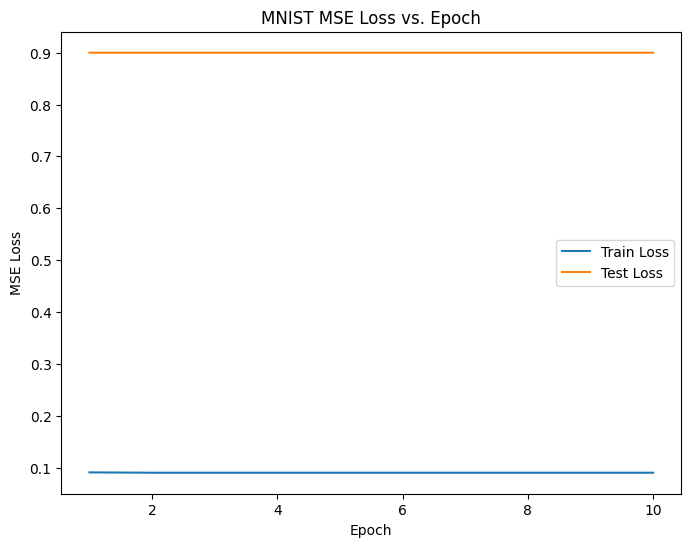

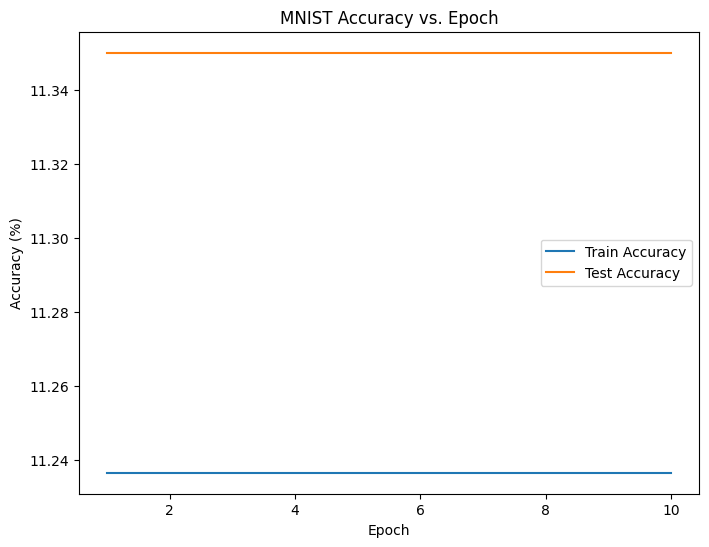

In [ ]:
plt.figure(figsize=(8, 6))
epochs_range = range(1, n_epochs + 1)
plt.plot(epochs_range, train_losses_per_epoch, label='Train Loss')
plt.plot(epochs_range, test_losses_per_epoch, label='Test Loss')
plt.title("MNIST MSE Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(epochs_range, np.array(train_accuracies)*100, label='Train Accuracy')
plt.plot(epochs_range, np.array(test_accuracies)*100, label='Test Accuracy')
plt.title("MNIST Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()